**Import libraries**

In [ ]:
!pip install scikit-posthocs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import shapiro
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import scikit_posthocs as sp
import itertools

np.random.seed(42)

**Load Data**

In [ ]:
df = pd.read_csv('data.csv', encoding='latin-1')
df.head()

#**Exploratory Data Analysis (EDA)**

In [ ]:
# Overview of data types + check for missing values and duplicates

df.info()
df.isnull().sum()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3472 entries, 0 to 3471
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Staff Group          3472 non-null   object 
 1   Name                 3472 non-null   object 
 2   Calculated Pay       3472 non-null   float64
 3   Total Hours          3472 non-null   float64
 4   Average Hourly Rate  3472 non-null   float64
 5   Division             3472 non-null   object 
 6   Vacancy Reason       3472 non-null   object 
 7   Pay Grade            3472 non-null   object 
 8   Bank/agency          3472 non-null   object 
dtypes: float64(3), object(6)
memory usage: 244.3+ KB


np.int64(0)

In [ ]:
# Descriptive Statistics
print(df[['Total Hours', 'Calculated Pay', 'Average Hourly Rate']].describe())

       Total Hours  Calculated Pay  Average Hourly Rate
count  3472.000000     3472.000000          3472.000000
mean    156.133228     5105.946610            36.801887
std     196.423328     8442.601461            28.948017
min       1.000000       12.620000             1.320000
25%      29.500000      915.730000            21.247500
50%      85.000000     2552.285000            28.120000
75%     201.812500     5918.880000            37.260000
max    1441.250000   136840.000000           261.990000


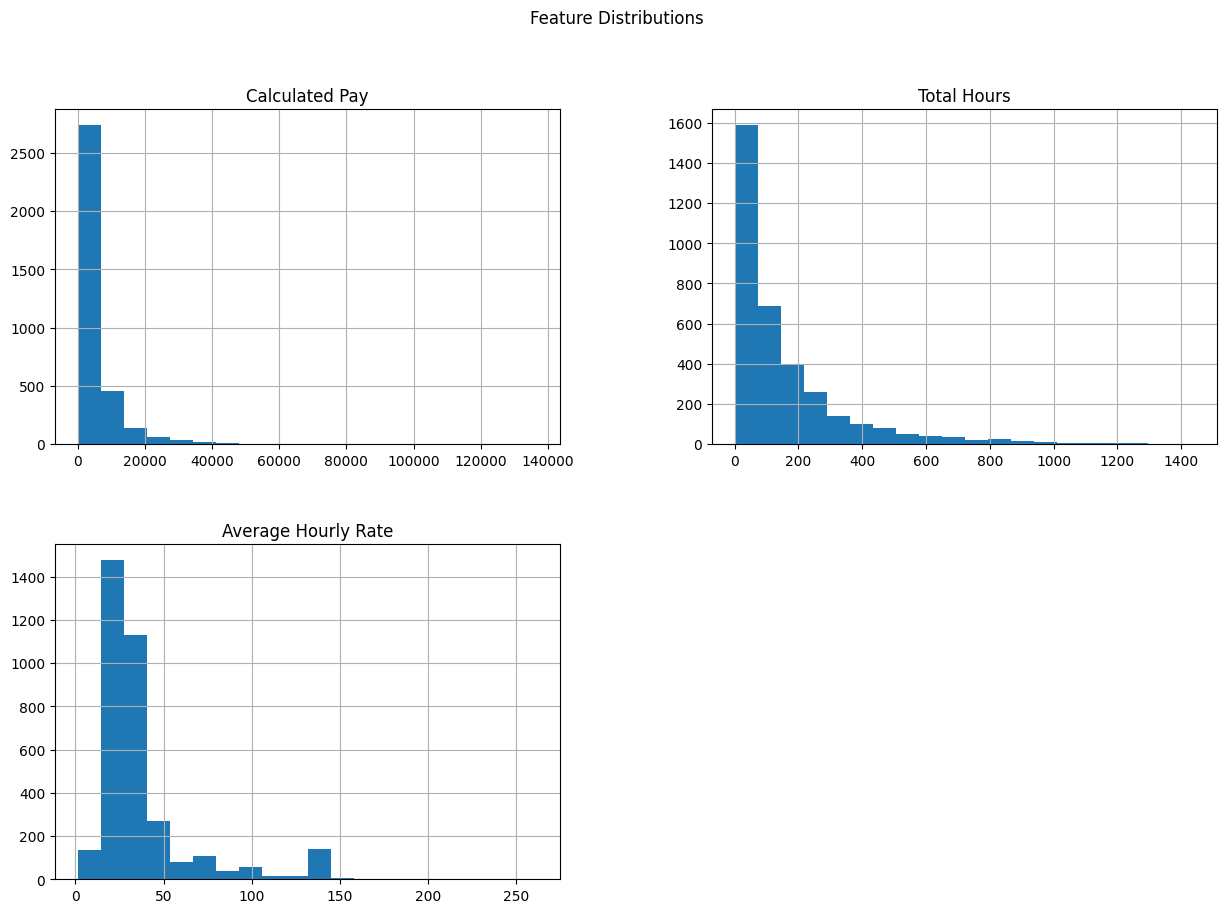

In [ ]:
# Distribution Plots
df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Feature Distributions')
plt.show()

**Removing Outliers**

In [ ]:
def remove_outliers_iqr(df, group_col, value_col):
    clean_df = pd.DataFrame()

    for group, group_df in df.groupby(group_col):
        Q1 = group_df[value_col].quantile(0.25)
        Q3 = group_df[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        filtered = group_df[(group_df[value_col] >= lower) & (group_df[value_col] <= upper)]
        clean_df = pd.concat([clean_df, filtered])

    return clean_df.reset_index(drop=True)

# Apply IQR removal
df_iqr = df.copy()
for col in ['Calculated Pay', 'Total Hours', 'Average Hourly Rate']:
    df_iqr = remove_outliers_iqr(df_iqr, group_col='Staff Group', value_col=col)

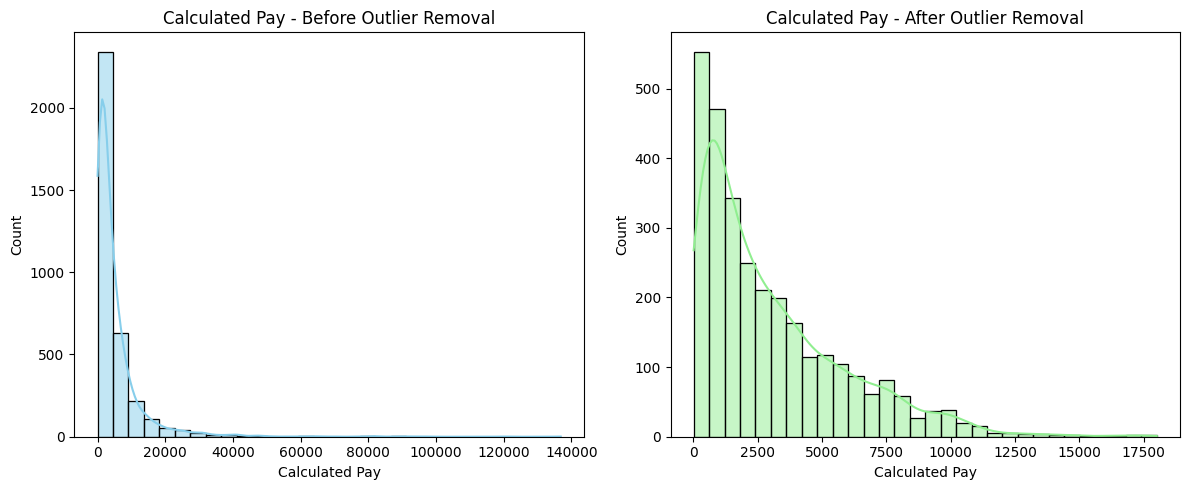

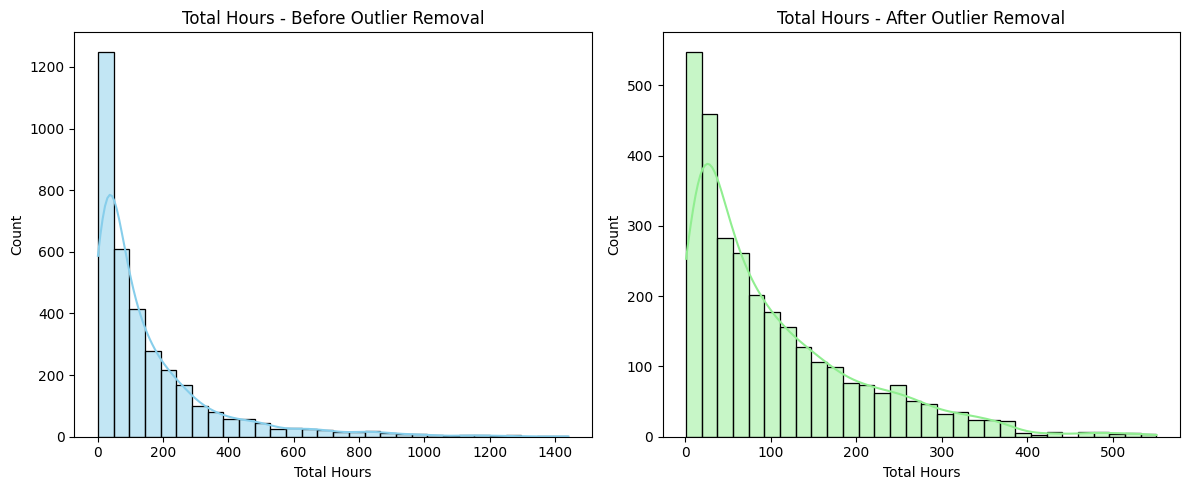

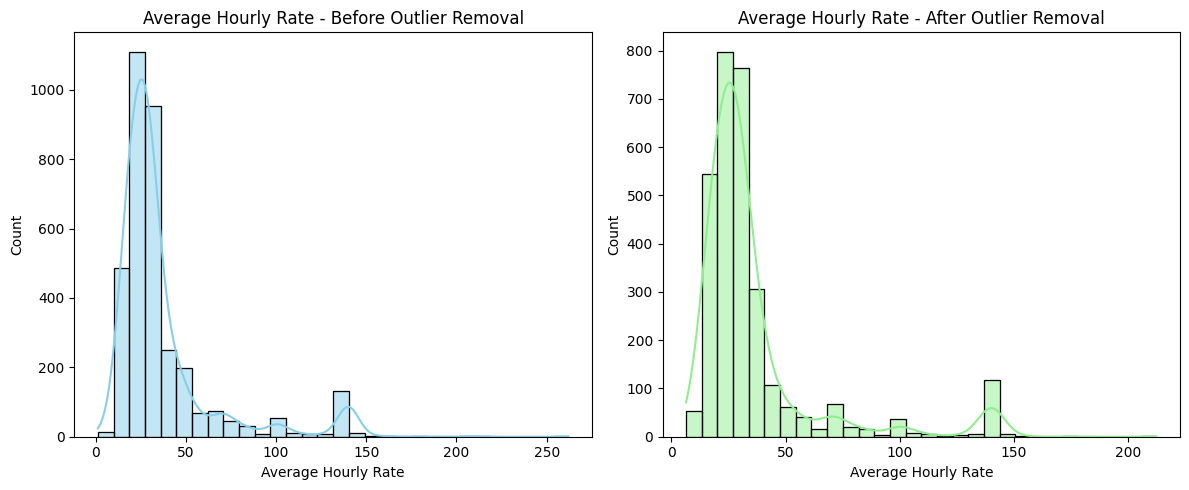

In [ ]:
# Distribution plots
for col in ['Calculated Pay', 'Total Hours', 'Average Hourly Rate']:
    plt.figure(figsize=(12, 5))

    # Before
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f"{col} - Before Outlier Removal")

    # After
    plt.subplot(1, 2, 2)
    sns.histplot(df_iqr[col], kde=True, bins=30, color='lightgreen')
    plt.title(f"{col} - After Outlier Removal")

    plt.tight_layout()
    plt.show()

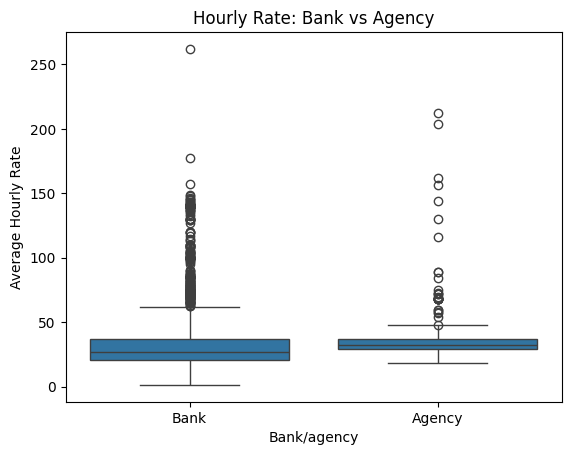

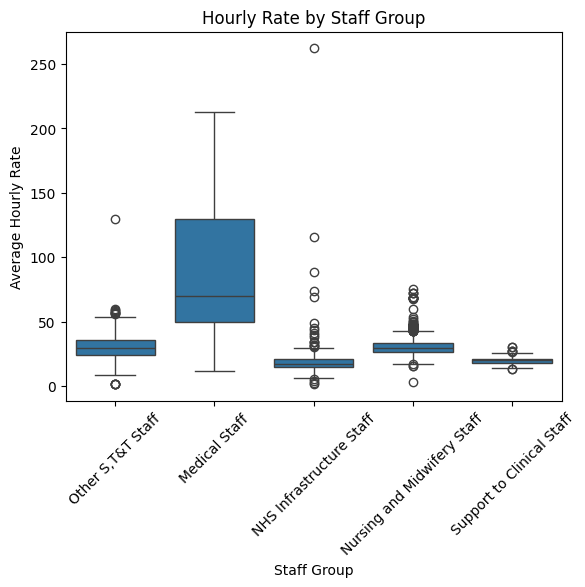

In [ ]:
# Boxplots - Hourly Rate: Bank vs Agency and Staff Groups

sns.boxplot(data=df[df['Bank/agency'].isin(['Bank', 'Agency'])], x='Bank/agency', y='Average Hourly Rate')
plt.title('Hourly Rate: Bank vs Agency')
plt.show()

sns.boxplot(data=df, x='Staff Group', y='Average Hourly Rate')
plt.xticks(rotation=45)
plt.title('Hourly Rate by Staff Group')
plt.show()

In [ ]:
# Log Transformation

# Create a copy of df
df_log = df_iqr.copy()

# Apply log transformation on the copy
df_log['log_pay'] = np.log1p(df_log['Calculated Pay'])
df_log['log_hours'] = np.log1p(df_log['Total Hours'])
df_log['log_rate'] = np.log1p(df_log['Average Hourly Rate'])

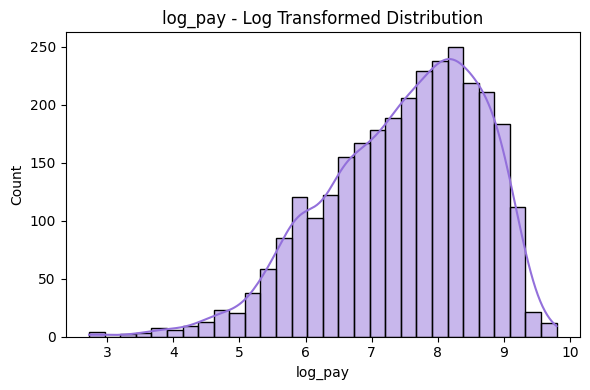

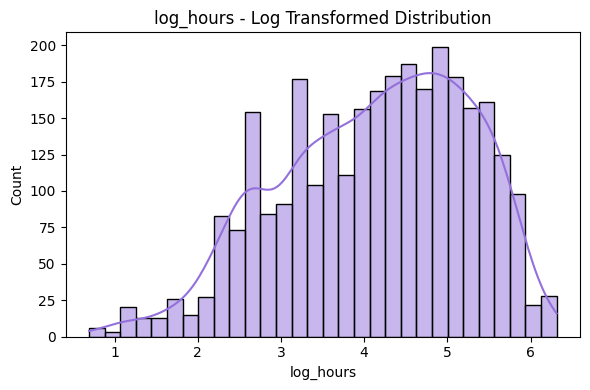

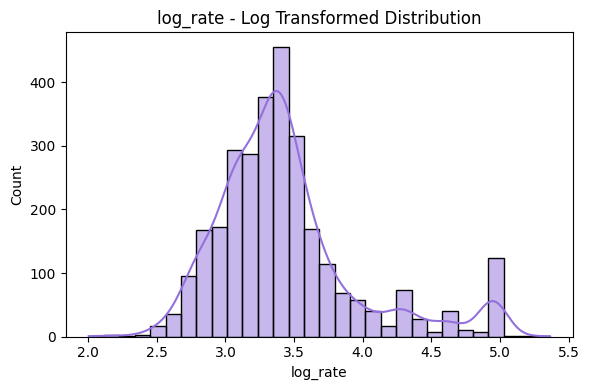

In [ ]:
for col in ['log_pay', 'log_hours', 'log_rate']:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_log[col], kde=True, bins=30, color='mediumpurple')
    plt.title(f"{col} - Log Transformed Distribution")
    plt.tight_layout()
    plt.show()

**Shapiro-Wilks:** Normality Tests

In [ ]:
stat, p = shapiro(df_log['log_rate'])
print(f"Shapiro-Wilk Test: W = {stat:.4f}, p = {p:.4f}")

if p > 0.05:
    print("Fail to reject H₀: Data is likely normal.")
else:
    print("Reject H₀: Data is likely not normal.")

Shapiro-Wilk Test: W = 0.8928, p = 0.0000
Reject H₀: Data is likely not normal.


In [ ]:
stat, p = shapiro(df_log['log_pay'])
print(f"Shapiro-Wilk Test: W = {stat:.4f}, p = {p:.4f}")

if p > 0.05:
    print("Fail to reject H₀: Data is likely normal.")
else:
    print("Reject H₀: Data is likely not normal.")

Shapiro-Wilk Test: W = 0.9666, p = 0.0000
Reject H₀: Data is likely not normal.


In [ ]:
stat, p = shapiro(df_log['log_hours'])
print(f"Shapiro-Wilk Test: W = {stat:.4f}, p = {p:.4f}")

if p > 0.05:
    print("Fail to reject H₀: Data is likely normal.")
else:
    print("Reject H₀: Data is likely not normal.")

Shapiro-Wilk Test: W = 0.9756, p = 0.0000
Reject H₀: Data is likely not normal.


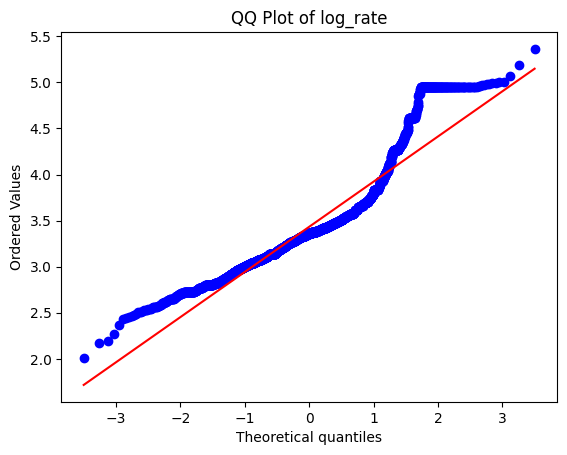

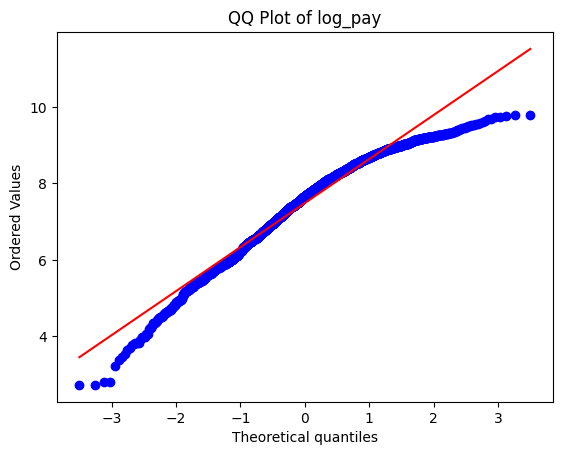

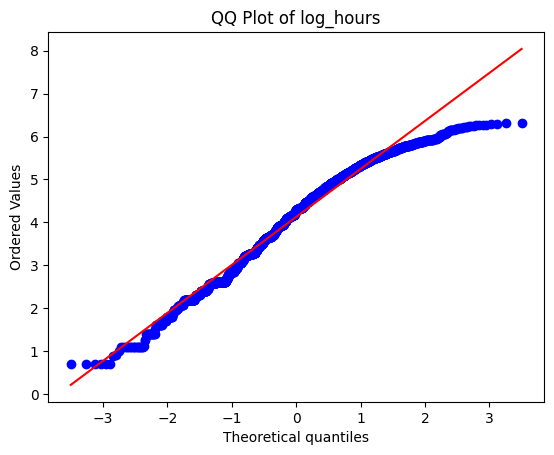

In [ ]:
# QQ plot

stats.probplot(df_log['log_rate'], dist="norm", plot=plt)
plt.title("QQ Plot of log_rate")
plt.show()

stats.probplot(df_log['log_pay'], dist="norm", plot=plt)
plt.title("QQ Plot of log_pay")
plt.show()

stats.probplot(df_log['log_hours'], dist="norm", plot=plt)
plt.title("QQ Plot of log_hours")
plt.show()

**Visualisations**

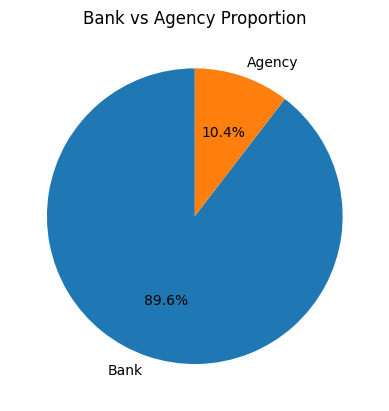

In [ ]:
# Bank vs Agency Proportion Pie Chart
bank_agency_counts = df_iqr['Bank/agency'].value_counts()
bank_agency_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Bank vs Agency Proportion")
plt.ylabel('')
plt.show()

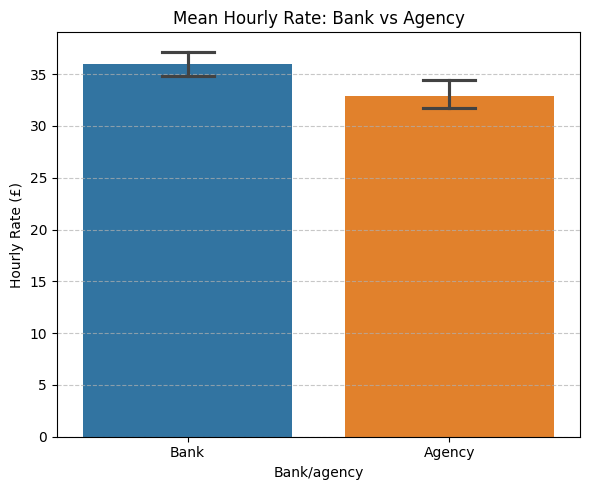

In [ ]:
# Filter to Bank and Agency only
df_plot = df_iqr[df_iqr['Bank/agency'].isin(['Bank', 'Agency'])]

# Average Hourly Rate Bank vs Agency
plt.figure(figsize=(6, 5))
sns.barplot(
    data=df_plot,
    x='Bank/agency',
    y='Average Hourly Rate',
    estimator='mean',
    errorbar=('ci', 95),
    capsize=0.2,
    hue='Bank/agency', legend=False
)
plt.title("Mean Hourly Rate: Bank vs Agency")
plt.ylabel("Hourly Rate (£)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

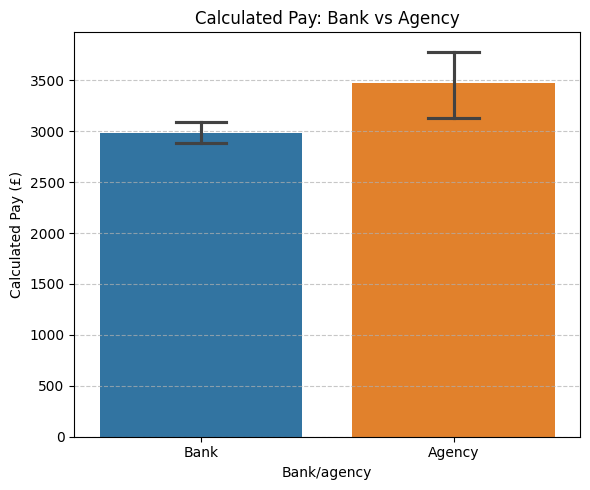

In [ ]:
# Calculated Pay Bank vs Agency
plt.figure(figsize=(6, 5))
sns.barplot(
    data=df_plot,
    x='Bank/agency',
    y='Calculated Pay',
    estimator='mean',
    errorbar=('ci', 95),
    capsize=0.2,
    hue='Bank/agency', legend=False
)
plt.title("Calculated Pay: Bank vs Agency")
plt.ylabel("Calculated Pay (£)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

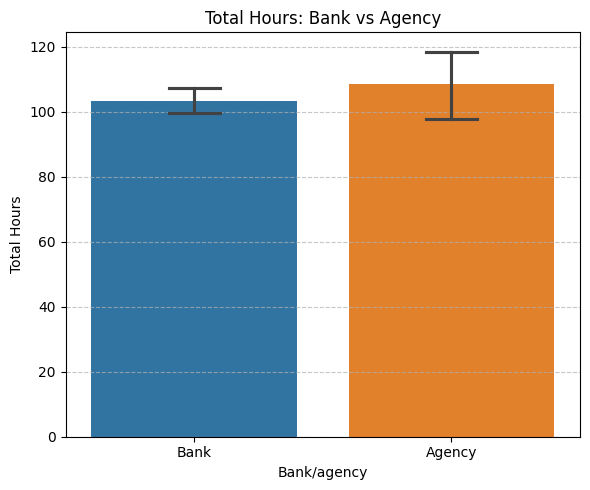

In [ ]:
# Total Hours Bank vs Agency
plt.figure(figsize=(6, 5))
sns.barplot(
    data=df_plot,
    x='Bank/agency',
    y='Total Hours',
    estimator='mean',
    errorbar=('ci', 95),
    capsize=0.2,
    hue='Bank/agency', legend=False
)
plt.title("Total Hours: Bank vs Agency")
plt.ylabel("Total Hours")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

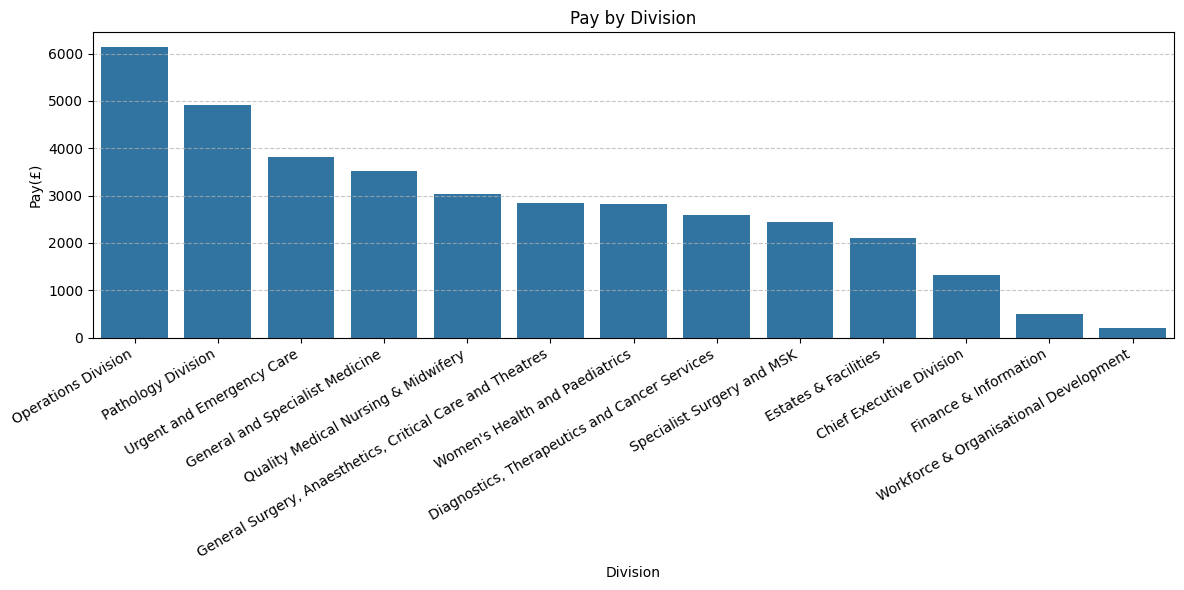

In [ ]:
# Highest Spending Divisions

division_order = df_iqr.groupby('Division')['Calculated Pay'].mean().sort_values(ascending=False).index


plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_iqr,
    x='Division',
    y='Calculated Pay',
    capsize=0.2,
    errorbar=None,
    order=division_order
)
plt.title("Pay by Division")
plt.ylabel("Pay(£)")
plt.xlabel("Division")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

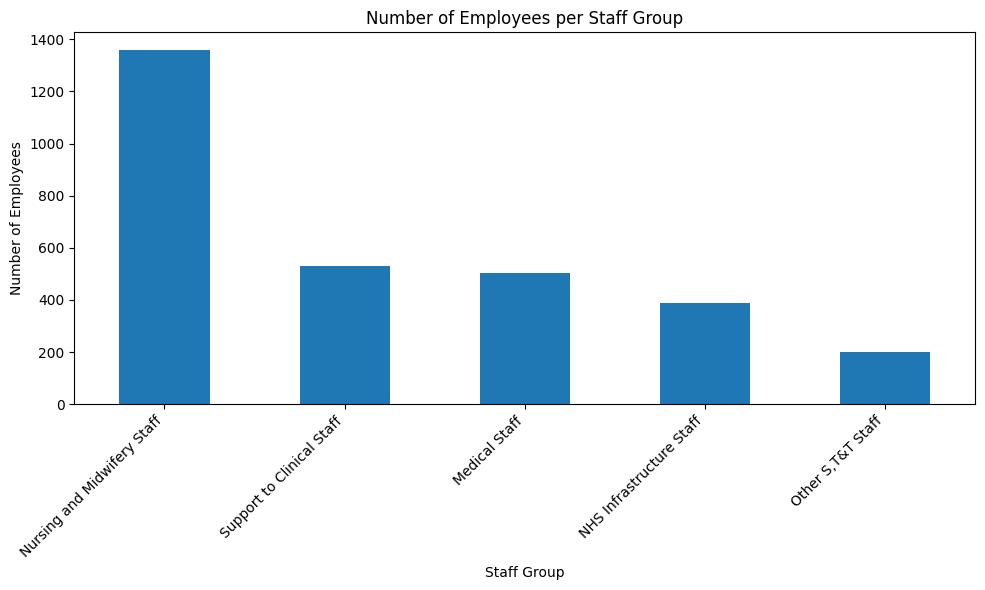

In [ ]:
# Count number of employees per staff group
staff_counts = df_iqr['Staff Group'].value_counts(ascending=False)

plt.figure(figsize=(10, 6))
staff_counts.plot(kind='bar')
plt.title('Number of Employees per Staff Group')
plt.xlabel('Staff Group')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

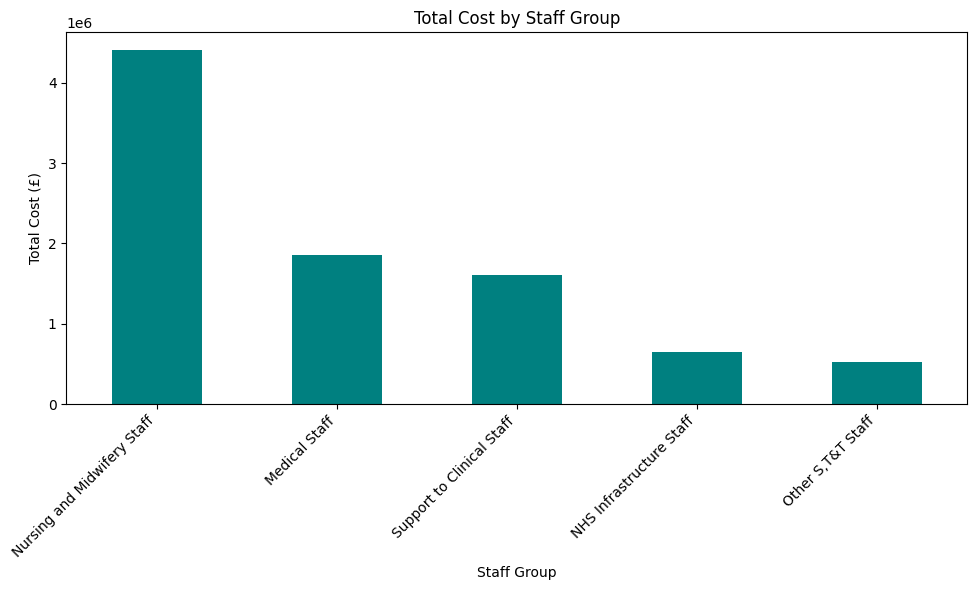

In [ ]:
# Cost by Staff Group
cost_by_group = df_iqr.groupby('Staff Group')['Calculated Pay'].sum().sort_values(ascending=False)

# Plotting the total cost by staff group
plt.figure(figsize=(10, 6))
cost_by_group.plot(kind='bar', color='teal')
plt.title('Total Cost by Staff Group')
plt.xlabel('Staff Group')
plt.ylabel('Total Cost (£)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

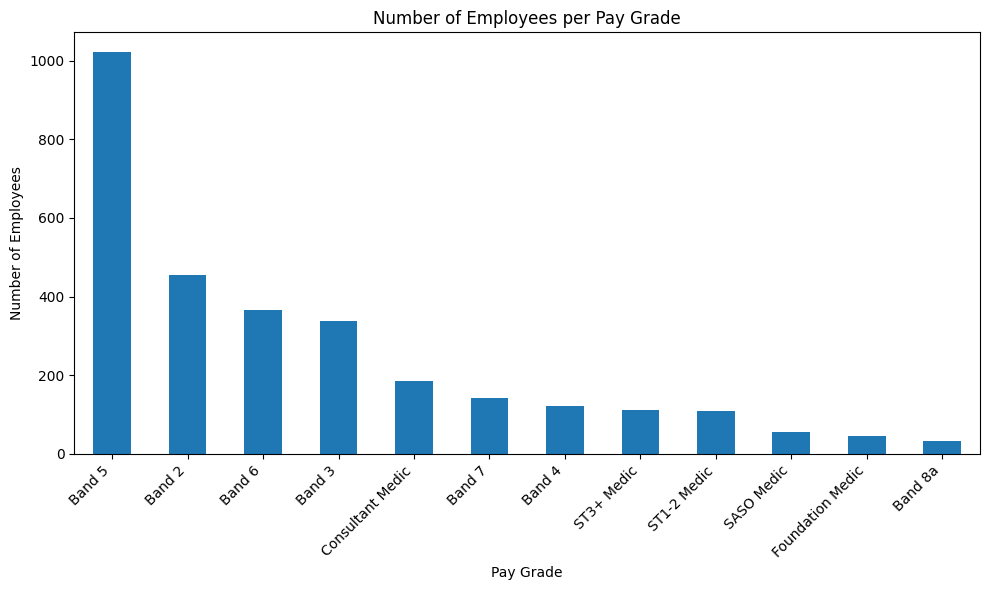

In [ ]:
# Count number of employees per Pay Grade
grade_counts = df_iqr['Pay Grade'].value_counts(ascending=False)

plt.figure(figsize=(10, 6))
grade_counts.plot(kind='bar')
plt.title('Number of Employees per Pay Grade')
plt.xlabel('Pay Grade')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

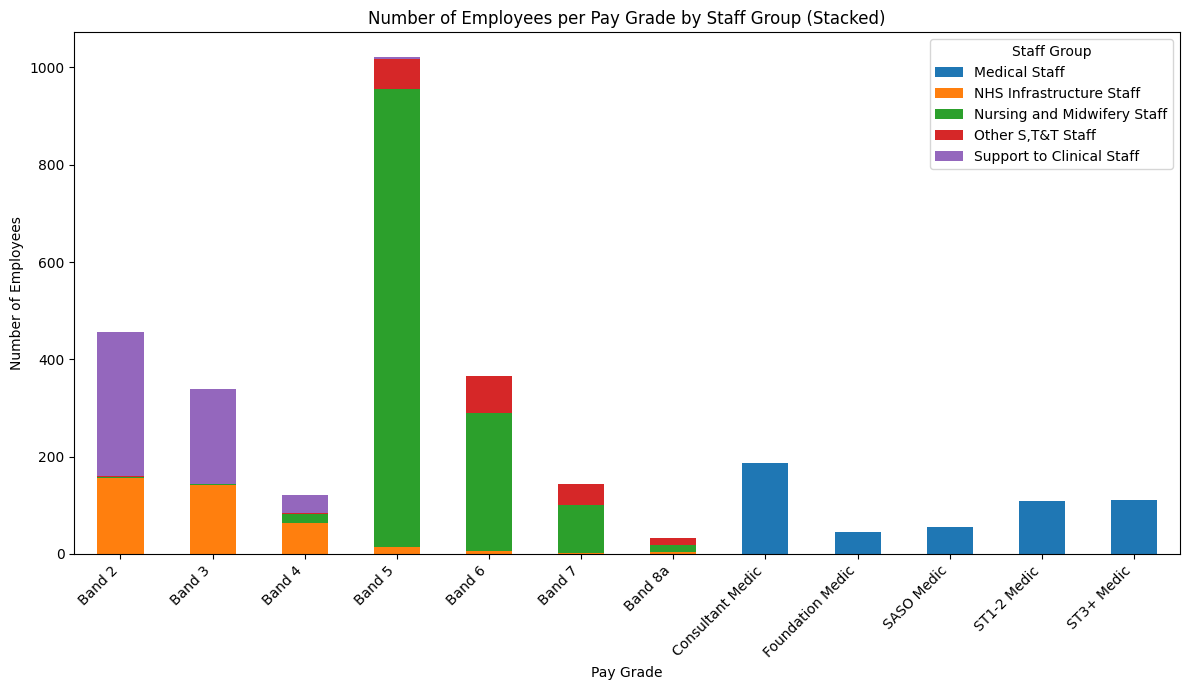

In [ ]:
# Comparing Staff Groups across each Pay Grade

grouped_counts = pd.crosstab(df_iqr['Pay Grade'], df_iqr['Staff Group'])

grouped_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Number of Employees per Pay Grade by Staff Group (Stacked)')
plt.xlabel('Pay Grade')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Staff Group')
plt.tight_layout()
plt.show()

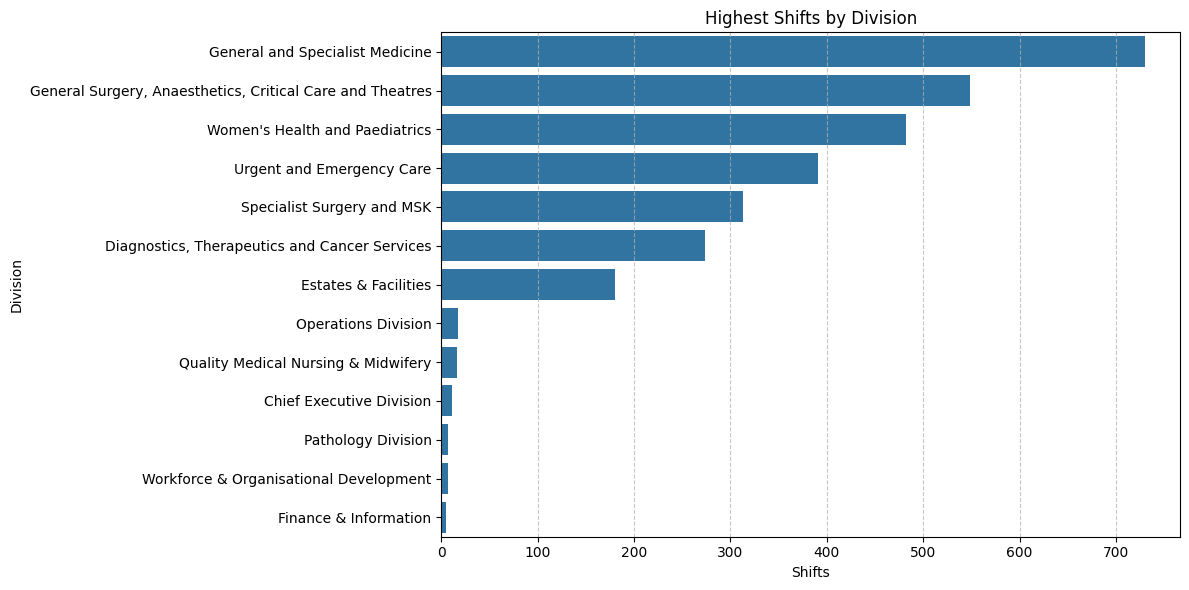

In [ ]:
# Highest usage of Temporary Staff by Division

shifts = df_iqr['Division'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    y=shifts.index,
    x=shifts.values,
)
plt.title("Highest Shifts by Division")
plt.xlabel("Shifts")
plt.ylabel("Division")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

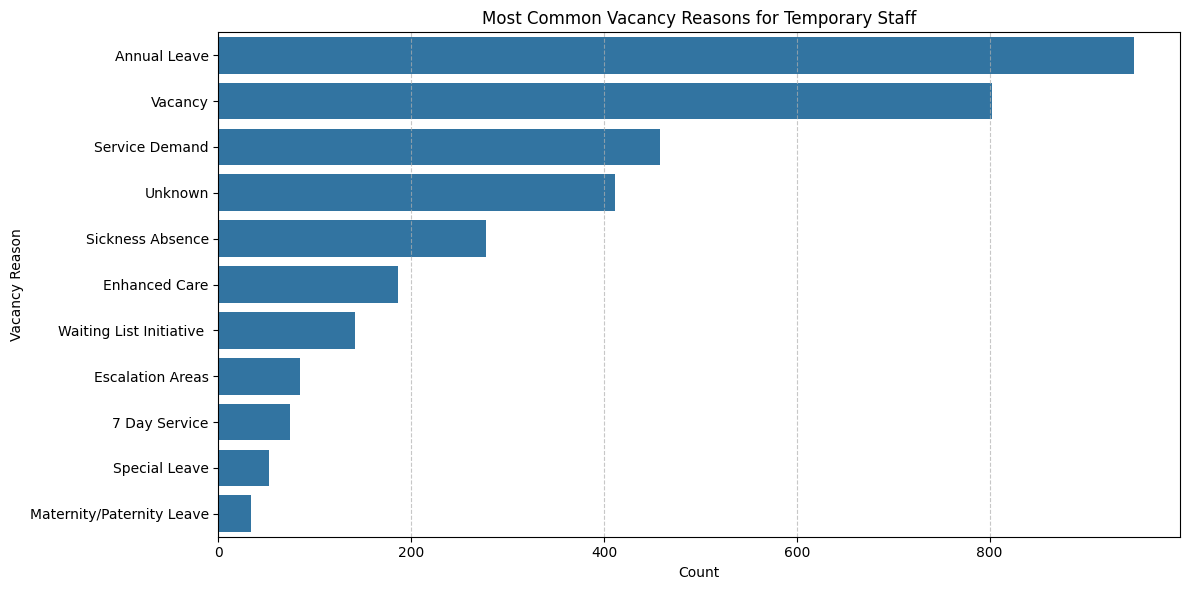

In [ ]:
# Most Common Reason for Shifts

vacancy = df['Vacancy Reason'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    y=vacancy.index,
    x=vacancy.values,
)
plt.title("Most Common Vacancy Reasons for Temporary Staff")
plt.xlabel("Count")
plt.ylabel("Vacancy Reason")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

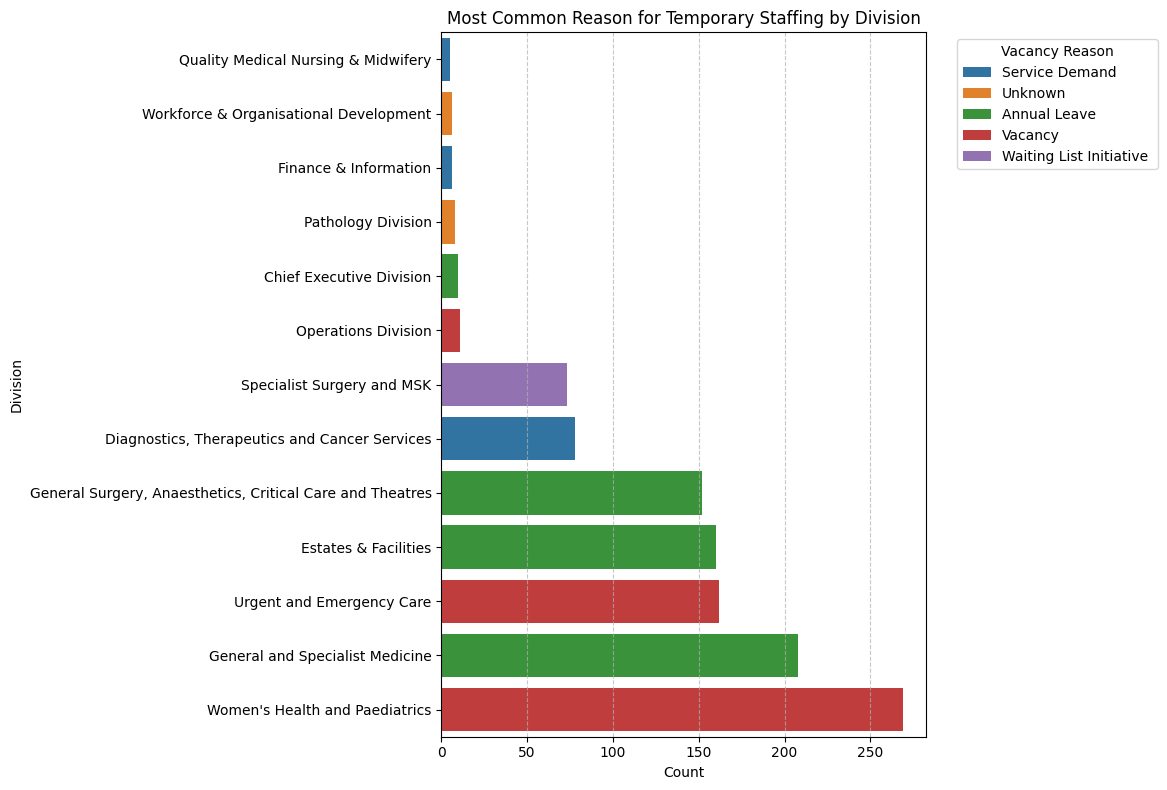

In [ ]:
# Group by Division and Vacancy Reason, then count occurrences
reason_by_division = df.groupby(['Division', 'Vacancy Reason']).size().reset_index(name='Count')

# For each division, get the most common reason
most_common_reason = reason_by_division.sort_values('Count', ascending=False).drop_duplicates('Division')

most_common_reason = most_common_reason.sort_values('Count', ascending=True)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=most_common_reason,
    y='Division',
    x='Count',
    hue='Vacancy Reason',
    dodge=False,
)
plt.title("Most Common Reason for Temporary Staffing by Division")
plt.xlabel("Count")
plt.ylabel("Division")
plt.legend(title="Vacancy Reason", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#**Data Analytics - Statistical Tests**

**Mann-Whitney U Tests:** Bank vs Agency

In [ ]:
# Subset by Bank vs Agency
bank = df_iqr[df_iqr['Bank/agency'] == 'Bank']
agency = df_iqr[df_iqr['Bank/agency'] == 'Agency']

In [ ]:
# Mann-Whitney U Tests
mwu_rate = stats.mannwhitneyu(bank['Average Hourly Rate'], agency['Average Hourly Rate'], alternative='two-sided')
mwu_pay = stats.mannwhitneyu(bank['Calculated Pay'], agency['Calculated Pay'], alternative='two-sided')
mwu_hours = stats.mannwhitneyu(bank['Total Hours'], agency['Total Hours'], alternative='two-sided')

In [ ]:
# Print Results
print("Mann-Whitney U Tests (Bank vs Agency)")
print(f"Hourly Rate: U={mwu_rate.statistic:.2f}, p={mwu_rate.pvalue:.4f}")
print(f"Calculated Pay: U={mwu_pay.statistic:.2f}, p={mwu_pay.pvalue:.4f}")
print(f"Total Hours: U={mwu_hours.statistic:.2f}, p={mwu_hours.pvalue:.4f}")

Mann-Whitney U Tests (Bank vs Agency)
Hourly Rate: U=285340.00, p=0.0000
Calculated Pay: U=378996.50, p=0.0114
Total Hours: U=394887.00, p=0.1546


**Null Hypotheses (H₀):** There is no difference in the average hourly rate, calculated pay and total hours between Bank and Agency staff.

**Alternative Hypothesis (H₁):** There is a difference in the average hourly rate, calculated pay and total hours between Bank and Agency staff.

1.   **Hourly Rate**: The Mann-Whitney U test produced a significant result (p = 0.0000 > 0.05), and the null hypothesis is rejected, and Bank and Agency staff have a different distribution of hourly rates.

2.   **Calculated Pay**: The Mann-Whitney U test produced a significant result (p = 0.0114 > 0.05), and the null hypothesis is rejected, though less strong than Hourly Rate.

3.   **Total Hours**: The Mann-Whitney U test produced a non-significant result (p = 0.1546 < 0.05), and the null hypothesis cannot be rejected. No difference between the total hours worked between the two groups statistically.

**Kruskal-Wallis Tests: Staff Group Analysis**

In [ ]:
kruskal_rate = stats.kruskal(*[group['Average Hourly Rate'].values for _, group in df_iqr.groupby('Staff Group')])
kruskal_pay = stats.kruskal(*[group['Calculated Pay'].values for _, group in df_iqr.groupby('Staff Group')])
kruskal_hours = stats.kruskal(*[group['Total Hours'].values for _, group in df_iqr.groupby('Staff Group')])


print("\nKruskal-Wallis Tests by Staff Group")
print(f"Hourly Rate: H={kruskal_rate.statistic:.2f}, p={kruskal_rate.pvalue:.4f}")
print(f"Calculated Pay: H={kruskal_pay.statistic:.2f}, p={kruskal_pay.pvalue:.4f}")
print(f"Total Hours: H={kruskal_hours.statistic:.2f}, p={kruskal_hours.pvalue:.4f}")


Kruskal-Wallis Tests by Staff Group
Hourly Rate: H=2201.90, p=0.0000
Calculated Pay: H=133.35, p=0.0000
Total Hours: H=291.47, p=0.0000


**Null Hypotheses (H₀):** There is no difference in the average hourly rate, calculated pay and total hours between Staff Groups.

**Alternative Hypothesis (H₁):** There is a difference in the average hourly rate, calculated pay and total hours between Staff Groups.

The tests produced statistically signficant results (p = 0.000 < 0.05), and the null hypothesis is rejected. Very strong evidence that at least one staff group has a significantly different hourly rate, calculated pay and total hours compared to others.

**Dunn's Test + Bonferroni Correction**

**Hourly Rate**

In [ ]:
dunn_results = sp.posthoc_dunn(df_iqr, val_col='Average Hourly Rate', group_col='Staff Group', p_adjust='bonferroni')
print(dunn_results)

                             Medical Staff  NHS Infrastructure Staff  \
Medical Staff                 1.000000e+00              0.000000e+00   
NHS Infrastructure Staff      0.000000e+00              1.000000e+00   
Nursing and Midwifery Staff  1.885579e-110             2.471566e-135   
Other S,T&T Staff             2.701189e-51              3.718800e-51   
Support to Clinical Staff     0.000000e+00              2.142347e-01   

                             Nursing and Midwifery Staff  Other S,T&T Staff  \
Medical Staff                              1.885579e-110       2.701189e-51   
NHS Infrastructure Staff                   2.471566e-135       3.718800e-51   
Nursing and Midwifery Staff                 1.000000e+00       1.000000e+00   
Other S,T&T Staff                           1.000000e+00       1.000000e+00   
Support to Clinical Staff                  6.479960e-136       4.803303e-44   

                             Support to Clinical Staff  
Medical Staff                      

In [ ]:
# Group Statistics: Median Hourly Rate by Staff Group

group_stats = df_iqr.groupby('Staff Group')['Average Hourly Rate'].median()
print(group_stats)

Staff Group
Medical Staff                  70.000
NHS Infrastructure Staff       17.520
Nursing and Midwifery Staff    29.040
Other S,T&T Staff              29.490
Support to Clinical Staff      19.965
Name: Average Hourly Rate, dtype: float64


In [ ]:
# Difference in Median Hourly Rate between Staff Groups
groups = group_stats.index.tolist()

diffs = {}
for g1, g2 in itertools.combinations(groups, 2):
    diff = group_stats[g1] - group_stats[g2]
    diffs[(g1, g2)] = diff

for pair, diff in diffs.items():
    print(f"Difference between {pair[0]} and {pair[1]}: {diff:.2f}")

Difference between Medical Staff and NHS Infrastructure Staff: 52.48
Difference between Medical Staff and Nursing and Midwifery Staff: 40.96
Difference between Medical Staff and Other S,T&T Staff: 40.51
Difference between Medical Staff and Support to Clinical Staff: 50.03
Difference between NHS Infrastructure Staff and Nursing and Midwifery Staff: -11.52
Difference between NHS Infrastructure Staff and Other S,T&T Staff: -11.97
Difference between NHS Infrastructure Staff and Support to Clinical Staff: -2.45
Difference between Nursing and Midwifery Staff and Other S,T&T Staff: -0.45
Difference between Nursing and Midwifery Staff and Support to Clinical Staff: 9.07
Difference between Other S,T&T Staff and Support to Clinical Staff: 9.52


In [ ]:
# Combined Median Differences + Dunn's

groups = group_stats.index.tolist()
summary_data = []

for g1, g2 in itertools.combinations(groups, 2):
    median_diff = group_stats[g1] - group_stats[g2]
    p_val = dunn_results.loc[g1, g2]
    summary_data.append({
        'Group 1': g1,
        'Group 2': g2,
        'Median Difference': median_diff,
        'Adjusted p-value': p_val
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Adjusted p-value')
print(summary_df)

                       Group 1                      Group 2  \
0                Medical Staff     NHS Infrastructure Staff   
3                Medical Staff    Support to Clinical Staff   
8  Nursing and Midwifery Staff    Support to Clinical Staff   
4     NHS Infrastructure Staff  Nursing and Midwifery Staff   
1                Medical Staff  Nursing and Midwifery Staff   
2                Medical Staff            Other S,T&T Staff   
5     NHS Infrastructure Staff            Other S,T&T Staff   
9            Other S,T&T Staff    Support to Clinical Staff   
6     NHS Infrastructure Staff    Support to Clinical Staff   
7  Nursing and Midwifery Staff            Other S,T&T Staff   

   Median Difference  Adjusted p-value  
0             52.480      0.000000e+00  
3             50.035      0.000000e+00  
8              9.075     6.479960e-136  
4            -11.520     2.471566e-135  
1             40.960     1.885579e-110  
2             40.510      2.701189e-51  
5            -11.97

Following the significant Kruskal-Wallis tests results (p < 0.0001), a Dunn's test was performed to assess pairwise differences in hourly rates between staff groups.

Medical Staff have a statistically significantly higher hourly rate than all other staff groups (p < 0.001 across all signficant comparisons). The median difference in hourly rate range from approximately £40.54 to £52.5 per hour, compared to:
* NHS Infrastructure Staff (+£52.5)
* Support to Clinical Staff (+£50)
* Nursing and Midwifery Staff (+£41)
* Other Scientific, Therapeutic & Technical Staff (+£40.5)

NHS Infrastructure Staff earn significantly less per hour than (adjusted p < 0.001):

*   Nursing and Midwifery Staff (-£11.5)
*   Other S,T&T Staff (-£11.9)

However, they do not differ significantly from Support to Clinical Staff (-£2.45, adjusted p = 0.214), suggesting these two groups have comparable hourly rates.

Nursing and Midwifery Staff and Other S,T&T Staff have similar hourly rates (-£0.45, adjusted p = 1.00), with no statistically significant difference detected.

Both Nursing and Midwifery Staff and Other S,T&T Staff earn significantly more than Support to Clinical Staff:

*  Nursing vs Support: +£9.08/hour, adjusted p < 0.001
*  Other S,T&T vs Support: +£9.53/hour, adjusted p < 0.001

**Conclusion**

The Medical Staff group is statistically the highest paid per hour, significantly exceeding all other staff groups. There is also clear stratification among other groups, with Support to Clinical Staff consistently earning the least, and NHS Infrastructure Staff occupying a middle-to-upper range alongside Medical Staff. These findings highlight the importance of segmenting pay analyses by staff group to accurately capture cost differences.


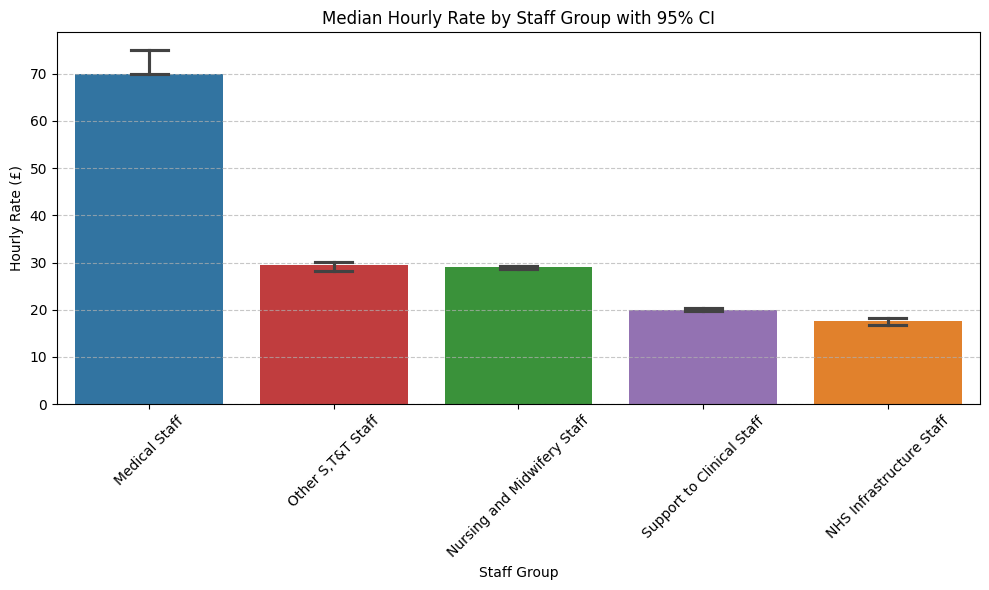

In [ ]:
staff_order = df_iqr.groupby('Staff Group')['Average Hourly Rate'].median().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_iqr,
    x='Staff Group',
    y='Average Hourly Rate',
    errorbar=('ci', 95),
    estimator='median',
    capsize=0.2,
    hue='Staff Group',
    legend=False,
    order=staff_order,
)
plt.title("Median Hourly Rate by Staff Group with 95% CI")
plt.ylabel("Hourly Rate (£)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Total Hours**

In [ ]:
dunn_results = sp.posthoc_dunn(df_iqr, val_col='Total Hours', group_col='Staff Group', p_adjust='bonferroni')
print(dunn_results)

                             Medical Staff  NHS Infrastructure Staff  \
Medical Staff                 1.000000e+00              3.159723e-15   
NHS Infrastructure Staff      3.159723e-15              1.000000e+00   
Nursing and Midwifery Staff   1.641552e-46              3.981064e-03   
Other S,T&T Staff             1.407900e-13              1.000000e+00   
Support to Clinical Staff     1.009764e-55              6.575609e-10   

                             Nursing and Midwifery Staff  Other S,T&T Staff  \
Medical Staff                               1.641552e-46       1.407900e-13   
NHS Infrastructure Staff                    3.981064e-03       1.000000e+00   
Nursing and Midwifery Staff                 1.000000e+00       1.000000e+00   
Other S,T&T Staff                           1.000000e+00       1.000000e+00   
Support to Clinical Staff                   5.710637e-05       3.731736e-04   

                             Support to Clinical Staff  
Medical Staff                      

In [ ]:
# Group Statistics: Median Total Hours by Staff Group

group_stats = df_iqr.groupby('Staff Group')['Total Hours'].median()
print(group_stats)

Staff Group
Medical Staff                   33.000
NHS Infrastructure Staff        60.250
Nursing and Midwifery Staff     84.000
Other S,T&T Staff               84.000
Support to Clinical Staff      110.125
Name: Total Hours, dtype: float64


In [ ]:
# Difference in Median Total Hours between Staff Groups
groups = group_stats.index.tolist()

diffs = {}
for g1, g2 in itertools.combinations(groups, 2):
    diff = group_stats[g1] - group_stats[g2]
    diffs[(g1, g2)] = diff

for pair, diff in diffs.items():
    print(f"Difference between {pair[0]} and {pair[1]}: {diff:.2f}")

Difference between Medical Staff and NHS Infrastructure Staff: -27.25
Difference between Medical Staff and Nursing and Midwifery Staff: -51.00
Difference between Medical Staff and Other S,T&T Staff: -51.00
Difference between Medical Staff and Support to Clinical Staff: -77.12
Difference between NHS Infrastructure Staff and Nursing and Midwifery Staff: -23.75
Difference between NHS Infrastructure Staff and Other S,T&T Staff: -23.75
Difference between NHS Infrastructure Staff and Support to Clinical Staff: -49.88
Difference between Nursing and Midwifery Staff and Other S,T&T Staff: 0.00
Difference between Nursing and Midwifery Staff and Support to Clinical Staff: -26.12
Difference between Other S,T&T Staff and Support to Clinical Staff: -26.12


In [ ]:
# Combined Median Differences + Dunn's

groups = group_stats.index.tolist()
summary_data = []

for g1, g2 in itertools.combinations(groups, 2):
    median_diff = group_stats[g1] - group_stats[g2]
    p_val = dunn_results.loc[g1, g2]
    summary_data.append({
        'Group 1': g1,
        'Group 2': g2,
        'Median Difference': median_diff,
        'Adjusted p-value': p_val
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Adjusted p-value')
print(summary_df)

                       Group 1                      Group 2  \
3                Medical Staff    Support to Clinical Staff   
1                Medical Staff  Nursing and Midwifery Staff   
0                Medical Staff     NHS Infrastructure Staff   
2                Medical Staff            Other S,T&T Staff   
6     NHS Infrastructure Staff    Support to Clinical Staff   
8  Nursing and Midwifery Staff    Support to Clinical Staff   
9            Other S,T&T Staff    Support to Clinical Staff   
4     NHS Infrastructure Staff  Nursing and Midwifery Staff   
7  Nursing and Midwifery Staff            Other S,T&T Staff   
5     NHS Infrastructure Staff            Other S,T&T Staff   

   Median Difference  Adjusted p-value  
3            -77.125      1.009764e-55  
1            -51.000      1.641552e-46  
0            -27.250      3.159723e-15  
2            -51.000      1.407900e-13  
6            -49.875      6.575609e-10  
8            -26.125      5.710637e-05  
9            -26.12

Following the significant Kruskal-Wallis tests results (p < 0.0001), a Dunn's test was performed to assess pairwise differences in hourly rates between staff groups.

Medical Staff work significantly fewer total hours than all other staff groups (adjusted p < 0.001 across all significant comparisons). The median differences in hours worked compared to other groups are:

* ~27 fewer hours than NHS Infrastructure Staff

* 51 fewer hours than Nursing and Midwifery Staff

* 51 fewer hours than Other Scientific, Therapeutic & Technical Staff

* ~77 fewer hours than Support to Clinical Staff

NHS Infrastructure Staff work significantly fewer hours than:

* Nursing and Midwifery Staff by 23.75 hours (adjusted p = 0.004)

* Other S,T&T Staff by 23.75 hours (adjusted p = 1.00, not significant)

* Support to Clinical Staff by 49.88 hours (adjusted p < 0.001)

There is no significant difference between Nursing and Midwifery Staff and Other S,T&T Staff (0 hours difference, adjusted p = 1.00).

Both Nursing and Midwifery Staff and Other S,T&T Staff work significantly fewer hours than Support to Clinical Staff by approximately 26.12 hours (adjusted p < 0.001).

Medical Staff have the lowest total hours worked, significantly less than all other groups, with the largest difference compared to Support to Clinical Staff. Support to Clinical Staff consistently work the most hours, while NHS Infrastructure Staff, Nursing and Midwifery Staff, and Other S,T&T Staff fall in between, with some groups showing similar workloads. These results highlight the importance of accounting for staff group when analysing workload distributions.


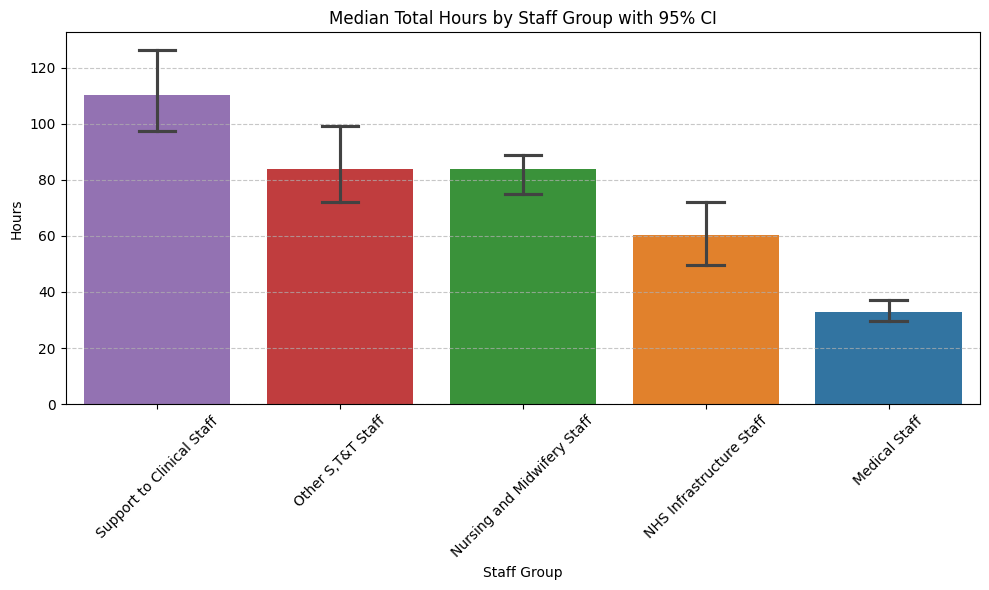

In [ ]:
staff_order = df_iqr.groupby('Staff Group')['Total Hours'].median().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_iqr,
    x='Staff Group',
    y='Total Hours',
    errorbar=('ci', 95),
    estimator='median',
    capsize=0.2,
    hue='Staff Group',
    legend=False,
    order=staff_order,
)
plt.title("Median Total Hours by Staff Group with 95% CI")
plt.ylabel("Hours")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#**Hierachical Clustering - Global**

In [ ]:
features = [
    'Staff Group', 'Total Hours', 'Average Hourly Rate',
    'Division', 'Vacancy Reason', 'Bank/agency', 'Pay Grade',
]
df_iqr = df_iqr [features]

**Numeric vs. Categorical Features**

In [ ]:
numeric_features = ['Total Hours', 'Average Hourly Rate']

categorical_features = ['Staff Group', 'Division', 'Vacancy Reason', 'Bank/agency', 'Pay Grade']

**Preprocess: scale numeric, encode categorical**

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

processed_data = preprocessor.fit_transform(df_iqr)
processed_df = pd.DataFrame(processed_data)

**Hierarchical Clustering**

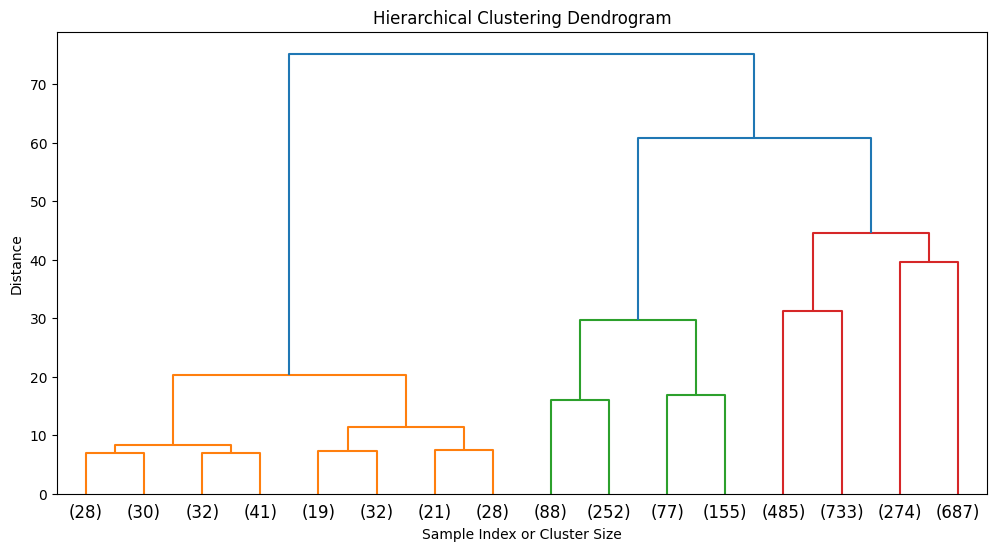

In [ ]:
linked = linkage(processed_df, method='ward')

# Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Choose number of clusters
n_clusters = 3
df_iqr['Cluster'] = fcluster(linked, n_clusters, criterion='maxclust')

/tmp/ipython-input-21-3870990876.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iqr['Cluster'] = fcluster(linked, n_clusters, criterion='maxclust')


In [ ]:
# Analyse clusters
cluster_summary = df_iqr.groupby('Cluster').agg({
    'Total Hours': 'median',
    'Average Hourly Rate': 'median',
    'Bank/agency': lambda x: x.value_counts().idxmax(),
    'Staff Group': lambda x: x.value_counts().idxmax(),
    'Vacancy Reason': lambda x: x.value_counts().idxmax(),
    'Division': lambda x: x.value_counts().idxmax(),
    'Pay Grade': lambda x: x.value_counts().idxmax()
})

cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary

,T_o_t_a_l_ _H_o_u_r_s,A_v_e_r_a_g_e_ _H_o_u_r_l_y_ _R_a_t_e,B_a_n_k_/_a_g_e_n_c_y,S_t_a_f_f_ _G_r_o_u_p,V_a_c_a_n_c_y_ _R_e_a_s_o_n,D_i_v_i_s_i_o_n,P_a_y_ _G_r_a_d_e
Cluster,,,,,,,
1,35.0,140.00,Bank,Medical Staff,Unknown,"General Surgery, Anaesthetics, Critical Care a...",Consultant Medic
2,255.0,26.08,Bank,Nursing and Midwifery Staff,Vacancy,General and Specialist Medicine,Band 5
3,50.5,27.08,Bank,Nursing and Midwifery Staff,Annual Leave,General and Specialist Medicine,Band 5


**Visualise Clusters**

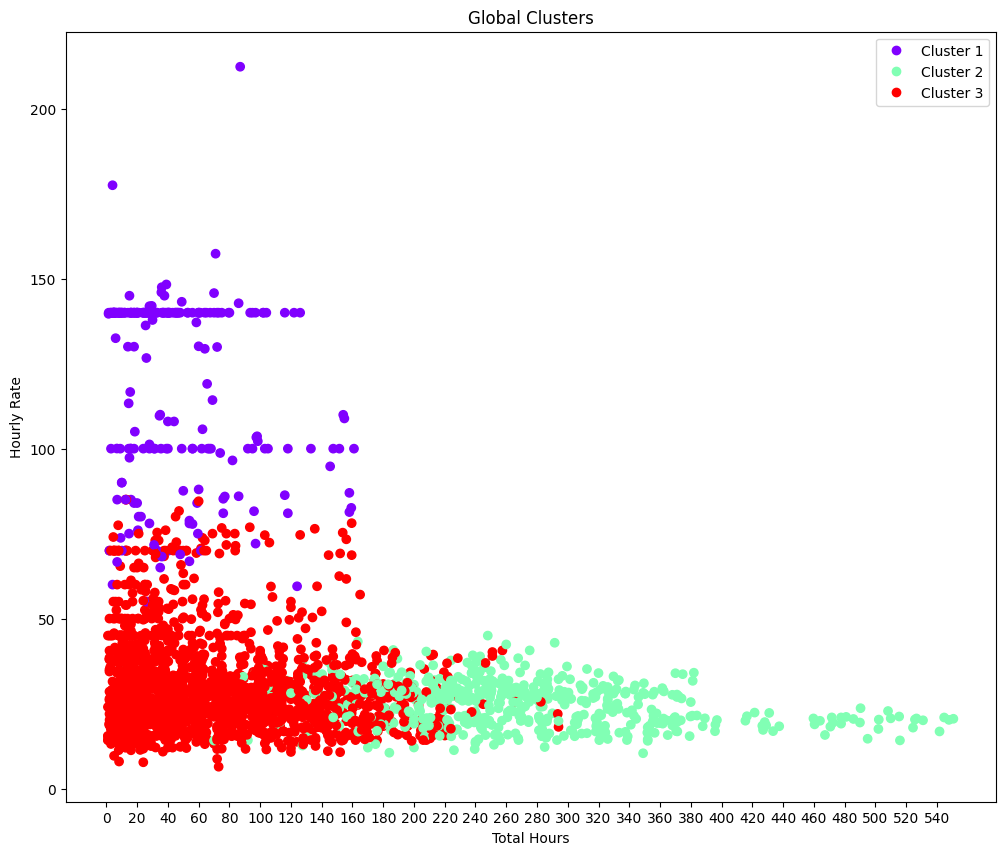

In [ ]:
plt.figure(figsize=(12, 10))

scatter = plt.scatter(df_iqr['Total Hours'], df_iqr['Average Hourly Rate'], c=df_iqr['Cluster'], cmap='rainbow')
plt.xlabel('Total Hours')
plt.ylabel('Hourly Rate')
plt.title('Global Clusters')

# Add legend
legend_labels = [f'Cluster {i + 1}' for i in range(n_clusters)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

x_min = df_iqr['Total Hours'].min()
x_max = df_iqr['Total Hours'].max()
plt.xticks(np.arange(0, x_max + 1, 20))

plt.show()

Hierarchical clustering was performed on all bank and agency staff using two years of aggregated data (June 2023 – June 2025), incorporating total hours worked, average hourly rate, and categorical variables including staff group and pay grade. The analysis identified three distinct clusters representing different patterns of workforce utilisation and cost behaviour. Due to the highly skewed nature of the data, medians were used as summary statistics. In particular, the median total hours worked may appear low, but this reflects the presence of many staff with low engagement across the two-year period, despite some individuals working high-intensity shifts.

Calculated Pay was not included in the clustering features as it is a direct product of Total Hours and Average Hourly Rate, hence including it would introduce redundancy and multicollinearity into the clustering model. This could distort distance calculations and lead to overweighting of pay-related dimensions, resulting in a cleaner, more interpretable segmentation.

* Cluster 1 consists of Consultant Medical Staff working a low median of 35 hours over the two-year period but at a very high average hourly rate (£140.00). These individuals represent short bursts of specialist activity with a high cost per hour, likely driven by urgent or highly specialised needs. Despite low engagement, they pose a significant cost impact and warrant focused workforce planning.

* Cluster 2 includes Band 5 Nursing and Midwifery Staff working a high median of 255 hours, at a modest hourly rate of £26.08. This group appears to be deployed extensively to fill long-term or recurring vacancies. They form a cost-effective and operationally essential segment of the temporary workforce.

* Cluster 3 features a similar nursing cohort (Band 5) but with limited engagement of just 50.5 hours median worked, and slightly higher hourly rates (£27.08). Their primary use is to cover planned absences (e.g., annual leave), offering flexible, low-cost staffing capacity.

**Recommendations:** Cluster 1 represents the most immediate target for cost efficiency. These individuals are likely being used for short, high-impact shifts, potentially to meet urgent clinical demands. While some use of this group is inevitable, closer scrutiny of the contexts driving their deployment is warranted. Where possible, these needs could be addressed by internal covering, improved rota planning, or expanding the pool of substantive staff to reduce dependency on expensive bank consultants. Cluster 2 contains Band 5 Nursing and Midwifery Staff working extensive hours to fill long-term or recurring gaps. Their consistent and high utilisation suggests structural vacancies that are being backfilled by temporary staff. Given their relatively low hourly rate, they represent a cost-effective solution, however, sustained reliance on this group implies underlying recruitment or retention issues. Investing in substantive recruitment and improving retention strategies in these clinical areas could yield long-term savings and improve continuity of care. Cluster 3 is similar to Cluster 2 but with lower engagement, primarily to cover short-term needs like annual leave. This is a natural and often unavoidable part of workforce management. However, the slight premium in their hourly rate suggests a potential area for small-scale cost improvements such as optimising the internal bank roster, ensuring that lower-band staff are prioritised for such shifts.


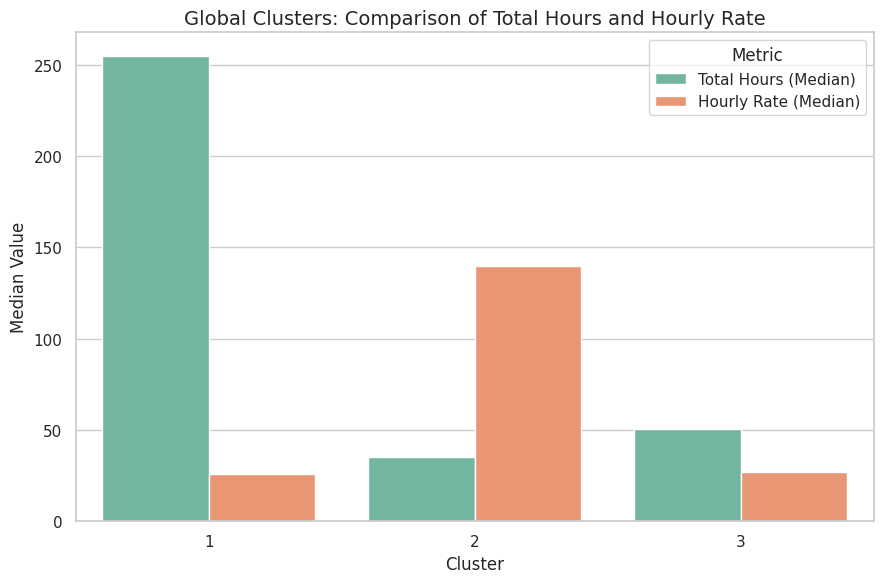

In [ ]:
# Global cluster summary data
global_clusters = pd.DataFrame({
    'Cluster': [1, 2, 3],
    'Total Hours (Median)': [255.0, 35.0, 50.5],
    'Hourly Rate (Median)': [26.08, 140.00, 27.08],
    'Staff Type': ['Nursing', 'Medical', 'Nursing'],
    'Pay Grade': ['Band 5', 'Consultant Medic', 'Band 5'],
    'Vacancy Reason': ['Vacancy', 'Unknown', 'Annual Leave'],
    'Division': ['General and Specialist Medicine',
                 'General Surgery, Anaesthetics, Critical Care and Cancer',
                 'General and Specialist Medicine']
})

# Melt for grouped bar chart
melted_global = global_clusters.melt(id_vars=['Cluster'],
                                     value_vars=['Total Hours (Median)', 'Hourly Rate (Median)'],
                                     var_name='Metric', value_name='Value')

# Set seaborn style
sns.set(style="whitegrid")
plt.figure(figsize=(9, 6))

# Barplot
sns.barplot(data=melted_global, x='Cluster', y='Value', hue='Metric', palette='Set2')

# Formatting
plt.title("Global Clusters: Comparison of Total Hours and Hourly Rate", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Median Value")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

#**Hierachical Clustering - Nursing**

In [ ]:
# Create a copy for nursing
df_nurse = df_iqr[df_iqr['Staff Group'] == 'Nursing and Midwifery Staff'].copy()

In [ ]:
features = [
    'Staff Group', 'Total Hours', 'Average Hourly Rate',
    'Division', 'Vacancy Reason', 'Bank/agency','Pay Grade'
]
df_nurse = df_nurse [features]

In [ ]:
numeric_features = ['Total Hours', 'Average Hourly Rate']

categorical_features = ['Staff Group', 'Division', 'Vacancy Reason', 'Bank/agency', 'Pay Grade']

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

processed_data = preprocessor.fit_transform(df_nurse)
processed_df_nurse = pd.DataFrame(processed_data)

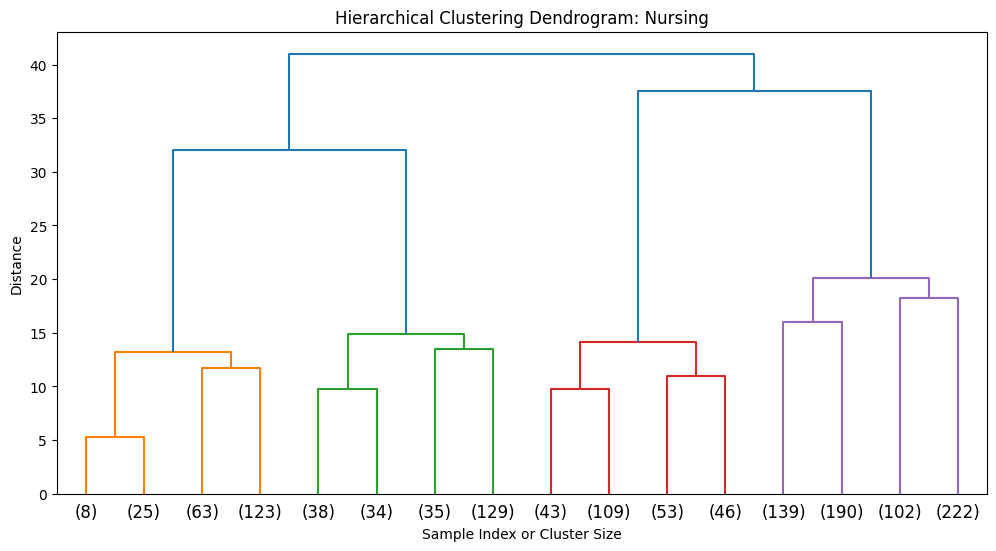

In [ ]:
linked = linkage(processed_df_nurse, method='ward')

# Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram: Nursing')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Choose number of clusters
n_clusters = 4
df_nurse['Cluster'] = fcluster(linked, n_clusters, criterion='maxclust')

In [ ]:
# Analyse clusters
cluster_summary = df_nurse.groupby('Cluster').agg({
    'Total Hours': 'median',
    'Average Hourly Rate': 'median',
    'Bank/agency': lambda x: x.value_counts().idxmax(),
    'Vacancy Reason': lambda x: x.value_counts().idxmax(),
    'Division': lambda x: x.value_counts().idxmax(),
    'Pay Grade': lambda x: x.value_counts().idxmax(),
})

cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary

,T_o_t_a_l_ _H_o_u_r_s,A_v_e_r_a_g_e_ _H_o_u_r_l_y_ _R_a_t_e,B_a_n_k_/_a_g_e_n_c_y,V_a_c_a_n_c_y_ _R_e_a_s_o_n,D_i_v_i_s_i_o_n,P_a_y_ _G_r_a_d_e
Cluster,,,,,,
1,49.000,31.820,Agency,Enhanced Care,General and Specialist Medicine,Band 5
2,62.625,36.535,Bank,Vacancy,Women's Health and Paediatrics,Band 6
3,251.250,28.170,Bank,Vacancy,General and Specialist Medicine,Band 5
4,63.750,27.330,Bank,Annual Leave,General and Specialist Medicine,Band 5


**Visualise Clusters**

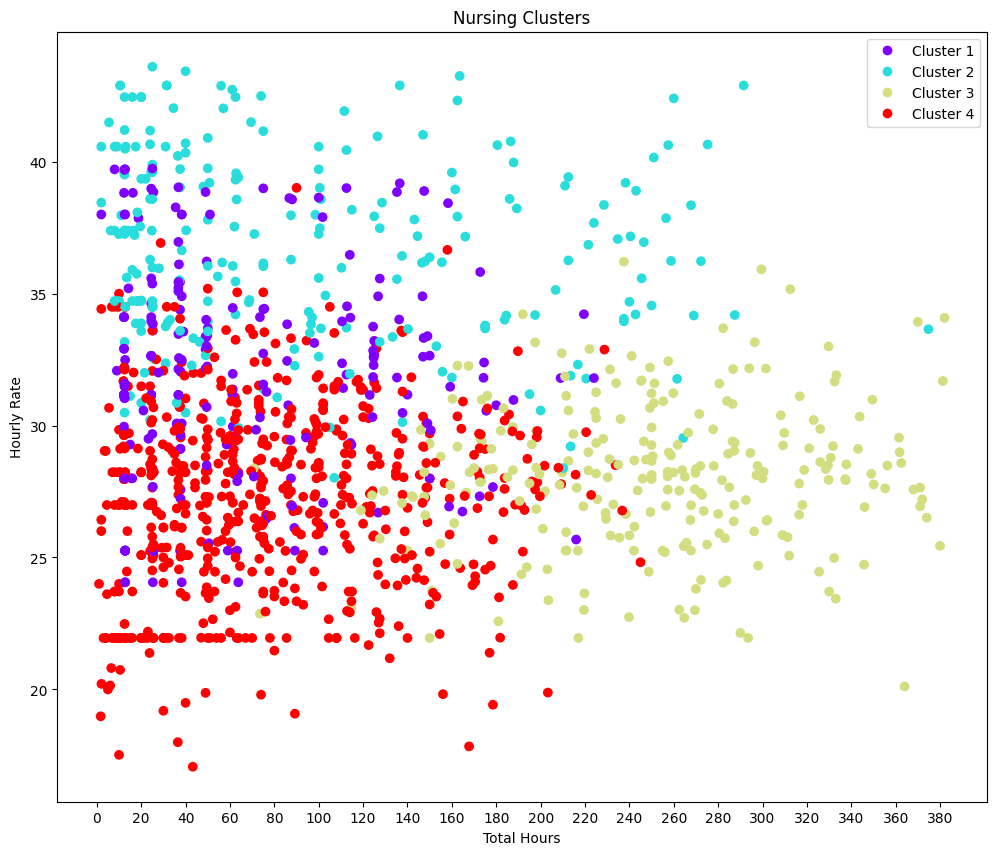

In [ ]:
plt.figure(figsize=(12, 10))

scatter = plt.scatter(df_nurse['Total Hours'], df_nurse['Average Hourly Rate'], c=df_nurse['Cluster'], cmap='rainbow')
plt.xlabel('Total Hours')
plt.ylabel('Hourly Rate')
plt.title('Nursing Clusters')

# Add legend
legend_labels = [f'Cluster {i + 1}' for i in range(n_clusters)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

x_min = df_nurse['Total Hours'].min()
x_max = df_nurse['Total Hours'].max()
plt.xticks(np.arange(0, x_max + 1, 20))


plt.show()

Clustering limited to Nursing Staff identified four distinct cost behavior clusters:

Cluster 1 reflects low-utilisation agency nurses who command a higher hourly rate.Although their total hours are relatively low (median: 49), they command a higher hourly rate (£31.82/hour), suggesting cost inefficiency in using agency for low-duration coverage. Although they work relatively few hours, the use of agency staff for enhanced care needs in Band 5 roles may indicate cost-inefficient resourcing.

Cluster 2 are mid-senior nurses (Band 6) used to fill vacancy gaps, particularly in Women’s Health. While their median hours are moderate (62.6), they have the highest hourly rate (£36.54). A This may warrant review of staffing models for enhanced care provision. The high hourly rate suggests specialised skills or urgency. While their usage is costlier per hour, they may provide value through expertise.

Cluster 3 represents long-term, lower-cost bank staff regularly covering vacancies. Their higher total hours (median: 251 hours) and lower hourly rate (£28.17) make them the most cost-efficient supplemental resource, especially compared to agency alternatives. This is likely the most sustainable model for bridging long-term vacancies.

Cluster 4 are used primarily for planned, short-term coverage of annual leave, with reasonable cost and a typical Band 5 rate.  This pattern aligns well with predictable workforce planning.

**Recommendations:** Reduce Agency Dependence (Cluster 1): Prioritise bank staff or increase internal coverage for enhanced care where possible. Agency usage in low-hour roles is likely cost-inefficient.

Retain and Expand Cluster 3 Patterns: Long-term bank staff offer the best cost-to-coverage ratio. Consider strategies to recruit and retain reliable bank staff for routine coverage.

Monitor High-Rate Bank Staff (Cluster 2): While skilled, this group is expensive per hour. Assess whether Band 6 staffing is necessary for the roles being filled — or if Band 5s could be substituted.


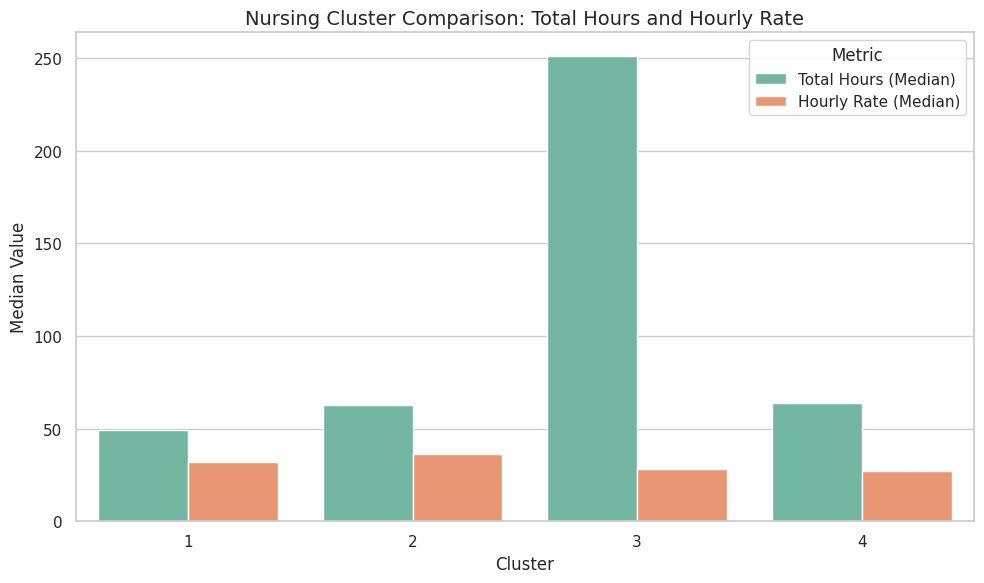

In [ ]:
# Cluster summary data
nurse_clusters = pd.DataFrame({
    'Cluster': [1, 2, 3, 4],
    'Total Hours (Median)': [49.000, 62.625, 251.250, 63.750],
    'Hourly Rate (Median)': [31.820, 36.535, 28.170, 27.330],
    'Staff Type': ['Agency', 'Bank', 'Bank', 'Bank'],
    'Vacancy Reason': ['Enhanced Care', 'Vacancy', 'Vacancy', 'Annual Leave'],
    'Pay Grade': ['Band 5', 'Band 6', 'Band 5', 'Band 5'],
    'Division': ['General and Specialist Medicine', 'Women’s Health and Paediatrics',
                 'General and Specialist Medicine', 'General and Specialist Medicine']
})

# Melt for dual feature plot
melted = nurse_clusters.melt(id_vars=['Cluster'],
                             value_vars=['Total Hours (Median)', 'Hourly Rate (Median)'],
                             var_name='Metric', value_name='Value')

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot
sns.barplot(data=melted, x='Cluster', y='Value', hue='Metric', palette='Set2')
plt.title("Nursing Cluster Comparison: Total Hours and Hourly Rate", fontsize=14)
plt.ylabel("Median Value")
plt.xlabel("Cluster")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

#**Hierachical Clustering - Medical**

In [ ]:
# Create a copy for Medical
df_med = df_iqr[df_iqr['Staff Group'] == 'Medical Staff'].copy()

In [ ]:
features = [
    'Staff Group', 'Total Hours', 'Average Hourly Rate',
    'Division', 'Vacancy Reason', 'Bank/agency', 'Pay Grade'
]
df_med = df_med [features]

In [ ]:
numeric_features = ['Total Hours', 'Average Hourly Rate']

categorical_features = ['Staff Group', 'Division', 'Vacancy Reason', 'Bank/agency', 'Pay Grade']

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

processed_data = preprocessor.fit_transform(df_med)
processed_df_med = pd.DataFrame(processed_data)

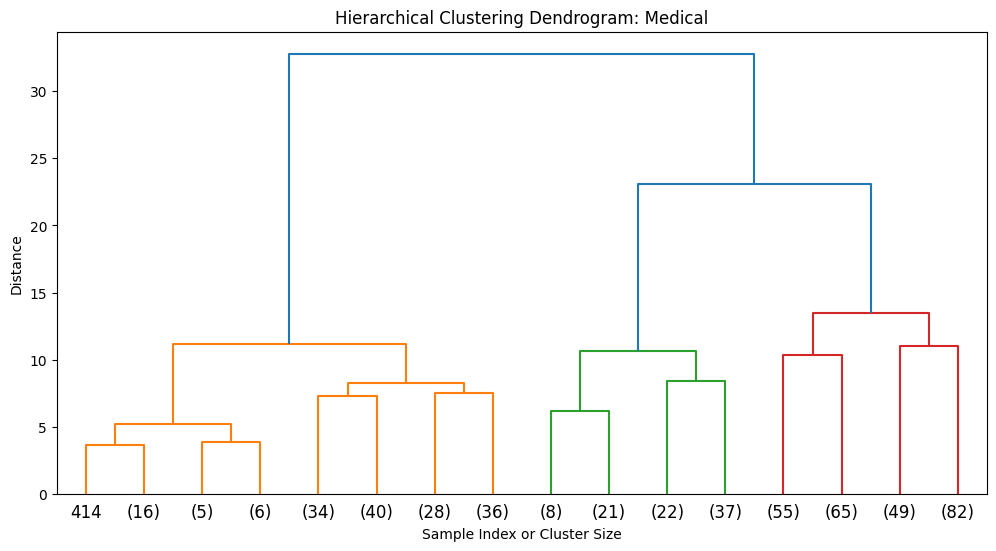

In [ ]:
linked = linkage(processed_df_med, method='ward')

# Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram: Medical')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Choose number of clusters
n_clusters = 3
df_med['Cluster'] = fcluster(linked, n_clusters, criterion='maxclust')

In [ ]:
# Analyse clusters
cluster_summary = df_med.groupby('Cluster').agg({
    'Total Hours': 'median',
    'Average Hourly Rate': 'median',
    'Bank/agency': lambda x: x.value_counts().idxmax(),
    'Vacancy Reason': lambda x: x.value_counts().idxmax(),
    'Division': lambda x: x.value_counts().idxmax(),
    'Pay Grade': lambda x: x.value_counts().idxmax(),
})

cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary

,T_o_t_a_l_ _H_o_u_r_s,A_v_e_r_a_g_e_ _H_o_u_r_l_y_ _R_a_t_e,B_a_n_k_/_a_g_e_n_c_y,V_a_c_a_n_c_y_ _R_e_a_s_o_n,D_i_v_i_s_i_o_n,P_a_y_ _G_r_a_d_e
Cluster,,,,,,
1,29.50,140.00,Bank,Unknown,"General Surgery, Anaesthetics, Critical Care a...",Consultant Medic
2,103.25,68.67,Bank,Unknown,Urgent and Emergency Care,ST3+ Medic
3,25.00,54.00,Bank,Vacancy,Women's Health and Paediatrics,ST1-2 Medic


Clustering limited to Medical Staff identified 3 distinct cost behavior clusters:

Cluster 1 consists of Consultant-grade locums working a low number of hours (29.5) but at a very high hourly rate (£140/hr). These are likely short-term, high-cost engagements, predominantly in General Surgery and Critical Care, where specialist cover is in high demand but used sparingly.

Cluster 2 includes mid-seniority doctors (ST3+) with a moderate rate (£68.67/hr) and higher working hours (103.25). These individuals appear to fill more sustained clinical demand, especially within Urgent and Emergency Care, indicating potential reliance on costly continuity cover at registrar level.

Cluster 3 is made up of junior doctors (ST1–2) working fewer hours (25) at a lower rate (£54/hr). These roles are mostly associated with vacancy backfill in Women’s Health and Paediatrics, suggesting a reliance on short-term staff to maintain service delivery in rota gaps.

**Recommendations:** Cluster 1 should be monitored closely. While specialists are essential, strategies such as internal rotation of in-house consultants could reduce the need for high-rate shifts. Cluster 2 represents a high cumulative cost due to both rate and volume. This may warrant workforce planning interventions to reduce reliance. Cluster 3 is lower risk financially but may highlight underlying junior doctor recruitment or retention issues in specific divisions.

**Visualise Clusters**

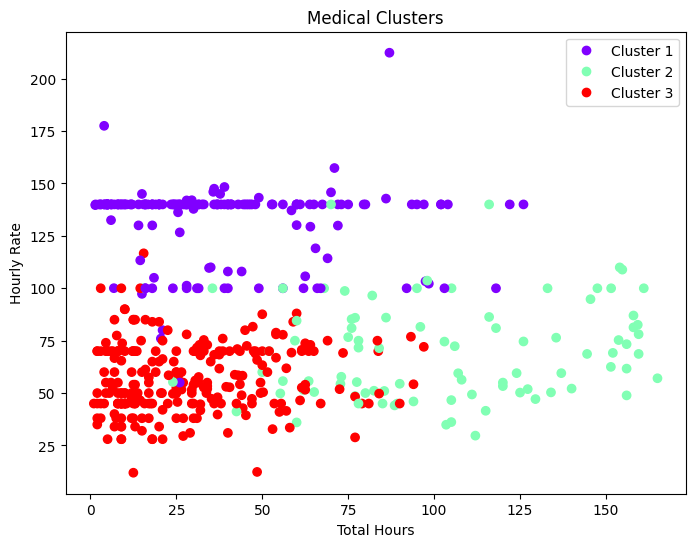

In [ ]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(df_med['Total Hours'], df_med['Average Hourly Rate'], c=df_med['Cluster'], cmap='rainbow')
plt.xlabel('Total Hours')
plt.ylabel('Hourly Rate')
plt.title('Medical Clusters')

# Add legend
legend_labels = [f'Cluster {i + 1}' for i in range(n_clusters)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.show()

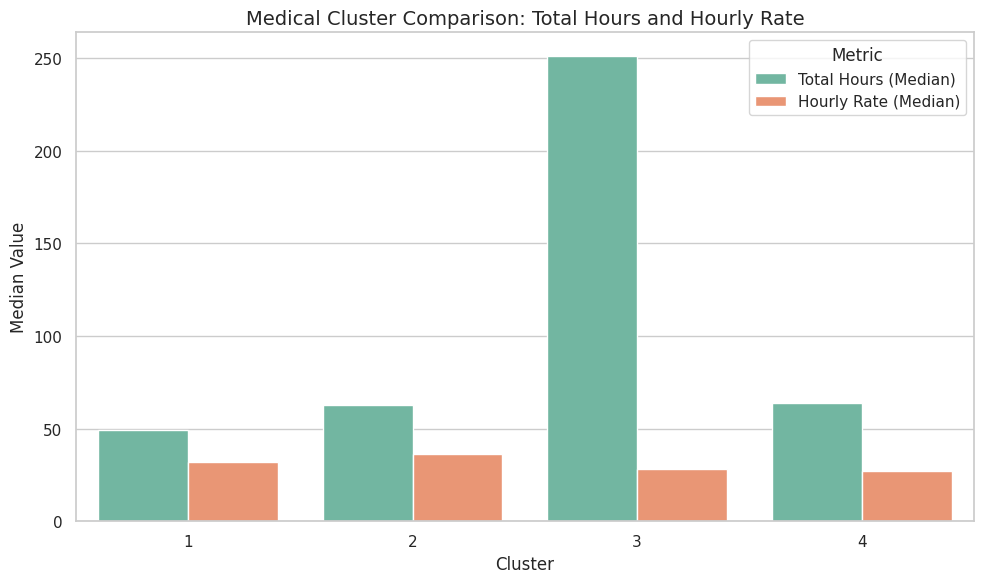

In [ ]:
# Cluster summary data
med_clusters = pd.DataFrame({
    'Cluster': [1, 2, 3],
    'Total Hours (Median)': [29.00, 103.25, 25.00],
    'Hourly Rate (Median)': [140.00, 68.67, 54.00],
    'Staff Type': ['Bank', 'Bank', 'Bank'],
    'Vacancy Reason': ['Unknown', 'Unknown', 'Vacancy'],
    'Pay Grade': ['Consultant Medic', 'ST3+ Medic', 'ST1-2 Medic'],
    'Division': ['General Surgery', 'Urgent and Emergency Care','Women’s Health and Paediatrics']
})

# Melt for dual feature plot
melted = nurse_clusters.melt(id_vars=['Cluster'],
                             value_vars=['Total Hours (Median)', 'Hourly Rate (Median)'],
                             var_name='Metric', value_name='Value')

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot
sns.barplot(data=melted, x='Cluster', y='Value', hue='Metric', palette='Set2')
plt.title("Medical Cluster Comparison: Total Hours and Hourly Rate", fontsize=14)
plt.ylabel("Median Value")
plt.xlabel("Cluster")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()